# _Python for Scientific Data Analysis_


#  Bayesian Statistics and Markov Chain Monte Carlo methods

## Section 2: Markov Chain Monte Carlo method

**caveats**

(caveat: a lot of this is HEAVILY indebted to Daniel Foreman-Mackey and Imad Pasha Please browse their work on https://dfm.io/ and https://prappleizer.github.io/.  I also borrowed a bit of text from Charles Greyer (U. Minnesota) )

(caveat #2: your instructor has a heavy frequentist bias by training but likes MCMC largely for its parameter space exploration and clear visualization of correlations between parameters in leading, widely-used code)

### Packages Used in This Notebook

The "machinery" of doing Monte Carlo methods will be handled by NumPy calls; most visualization by Matplotlib.   
We also want to plot modeling outputs.  Monte Carlo codes give us posterior distributions which then allows us to plot not just these distributions but correlations in the posterior distributions between different parameters in our model.   The widely-used package for this is the logically-named ``corner`` package.  Note that making the output from simple Monte Carlo code "work" with ``corner`` takes a few extra steps but hopefully this is clear.  

We will eventually be using the ``emcee`` package for doing MCMC, a Python implementation of the affine-invariant ensemble sampler for Markov chain Monte Carlo (MCMC) (Goodman and Weare 2010).   It makes up the engine of many MCMC codes used today (e.g. the dynamical code ``orvara``).   

You can install ``emcee`` and ``corner`` from pip or from conda:

E.g.
```
pip install corner
pip install emcee
```

We will then import these packages along with our standard import calls for doing numerical Python and displaying data:

In [164]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import corner
import emcee

Before we dive into running MCMC, we need to understand what it is we are actually doing.

### Background

MCMC stands for "Markov-Chain Monte Carlo": it is a special type of Monte Carlo simulation.  

We have previously discussed what we mean by the last two words (Monte Carlo).  A "Monte Carlo" simulation is a name for a simulation of probability distributions and calculating probabilities and expectations by averaging over the simulations.  Monte Carlo methods use **random sampling** to approximate quantities that are difficult to compute directly. The basic idea:

1.  Draw many random samples from a known distribution.
2.  Use those samples to approximate integrals, expectations, or
    uncertainties.

Now "Markov Chain".  Named after Russian mathematician Andrei Markov, a Markov Chain is a sequence of random variables whose probability at a given time $t+1$ only depends on the variables at time $t$.  

With MCMC, you start with an ensemble of Markov Chains with imposed starting points that provide some sampling of the _prior_ distribution of parameter space.  These chains are stochastic processes of "walkers" which move around randomly according to an algorithm that looks for places with a reasonably high contribution to the integral to move into next, assigning them higher probabilities. 

This approach contrasts with the plain, vanilla Monte Carlo simulation which keeps uniformly sampling the parameter space regardless of whether that particular region of parameter space contributes to the integral much at all or contributes alot.   

A lot of the innovation in MCMC focuses in algorithms that tells the code _how_ to move.   The widely-used general framework for MCMC is the "Metropolis-Hastings" algorithm and describes the idea of "acceptance ratios" in telling a Markov Chain whether or not to move on to a new value or keep the old one.  It was worked on in part by Edwin Teller (aka father of the hydrogen bomb, aka quasi-villian in "Oppenheimer"), although as in "Oppenheimer" there is some question about truthfulness with Teller's accounts/how much he actually did -- see https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm -- and even more question about whether Metropolis did much at all!  We will get to this algorithm later in this section.

So then a "Markov Chain Monte Carlo" method is a Monte Carlo method that samples/explores an N-dimensional parameter space using Markov Chains.

### How MCMC Works

MCMC is a parameter space exploration tool: a *sampler*.  What do we mean by that? Remember the notes above about "Monte Carlo" methods.  Say your parameter space is super simple and there is some analytical solution to how the the prediction changes as you infinitesimally change a parameter: in the simplest case this could be an integral you can solve by hand.   Or you can just randomly sample the entire parameter space, weight each realized $\theta$ by its likelihood, and derive posterior distributions for parameters.

But say the parameter space of model variables that yields the best fidelity to the data is really, really small compared to the entire possible parameter space (but that you did not necessarily know what this space is in advance).  Or better yet, that it is multi-modal (i.e. that there are multiple regions of parameter space that are local minima).   Then, a simple Monte Carlo simulation is not going to be good enough.

The fundamental process of running an MCMC is to compare generated **models** (our set of $\theta$) against **data** ($x$). Those models are generated by a set of **parameters**, and our goal is usually to find the set of parameters that produces the model that best fits our data.   

Calculating the probability of our *model* given our *data* at first looks a bit like a simple Monte Carlo simulation. As in the simple MC example, you:

 - Establish a function that outputs a model given a set of input parameters

However, a _Markov Chain Monte Carlo_ simulation differs from plain Monte Carlo in two key respects.  

First:

- MCMC adopts a _prior probability_ for $\theta$ that is _not necessarily_ uniform.   The prior for a given parameter in the model could be, say, a gaussian centered on some value (i.e. a normal distribution)..   Or it could be a log-uniform (i.e. $pr(\theta_{a})$ $\propto$ 1/a).  Or _log-normal_, etc. etc.

Second: 
 
 - MCMC doesn't randomly explore parameter space without regard to whether that space has a high or low likelihood.  Instead, it establishes an ensemble of walkers each containing some range in parameters that make up $\theta$ (the model-generating function).  E.g. let's go back to our simple model of an RV signal from a planet.  Here, each walker $j$ starts with: 
 \begin{equation}\theta_{j} = \begin{pmatrix} M_{star_{j}} \\ Msin(i){_ j}\\ O_{0...n-1_{j}}\end{pmatrix} \end{equation}
  
 - And now they're off!  Every walker will now begin exploring the parameter space. To do this, each walker takes a "step" to a new value of $\theta$ (again, $\theta$ is just shorthand for "combination of parameters") and generates a model with that $\theta$. It then compares the model to the given data by some **likelihood function**.
 - The MCMC then checks the ratio of the likelihood generated by the new model with the data vs. the previous model. Generally speaking, if the new location in model phase space produces a better match, the walker moves there and repeats the process. If the new location is worse, it retreats to its previous position and tries a new direction. 
 - Eventually, the walkers all begin climbing towards the regions of highest "likelihood" between the models generated in the data.
 
At the end of the process, we have the **posterior distribution** or **chain**. Every walker keeps a record of every $\theta$ vector it tried out, and the likelihood of the model given the data at that value of $\theta$. 

Assuming the MCMC runs long enough to *converge* reasonably (that is, the distribution of walkers is not changing *en masse* as a function of step number), the posterior distribution represents a sample of reasonable models to describe our data.  For plain Monte Carlo, the posterior distribution for a given parameter is calculated as the average parameter value multipled by its likelihood.  For MCMC, the posterior distribution is calculated simply by the number density of solutions in for a given parameter.

Note that MCMC can't tell us that parameter set $\theta$ is the "best" - one our models will have the numerically highest value of "likelihood" to the data.  If we reran the MCMC again, or ran it longer, etc., we will slightly get different answers. Every. single. time. What MCMC is better at telling us is something like "if you draw 100 random models out of the posterior distribution, the *spread* in those models is representitive of our ability to constrain the parameters in those models."  I.e. rather than just computing a "best fit" combination of parameters, MCMC lets us figure out a most likely set of parameters and the uncertainties on these parameters.  

### A Good Sampler is the Engine Behind MCMC (e.g. Metropolis-Hastings Algorithm)

The Metropolis-Hastings algorithm is remarkably simple yet powerful.   Consider a vector $\theta$ whose log-likelihood is $ln{p}(x|\theta)$, which for (slightly improved) simplicity we write as $\pi(\theta)$.

Starting from an initial vector $\theta^{(0)}$ do the following three things in a loop with length $N_{steps}$: 

#### 1. Proposal Vector
Generate a candidate state from a proposal distribution:
$\theta^* = \theta^{(t)} + \text{stepsize} \cdot \mathcal{N}(0, I)$

#### 2. Calculate Acceptance Probability of Proposal Vector
In log-space compute:

$\log \alpha = \log \pi(\theta^*) - \log \pi(\theta^{(t)})$

(more precisely, this is $\log \alpha = \min(0, \log \pi(\theta^*) - \log \pi(\theta^{(t)}))$)

#### 3. Acceptance or Rejection Criterion: Keep the Old Vector or Use the New One?
- Draw $u \sim \text{Uniform}(0,1)$
- If $\log u < \log \alpha$: set $\theta^{(t+1)} = \theta^*$ (accept)
- Otherwise: set $\theta^{(t+1)} = \theta^{(t)}$ (reject, stay put)



Or crudely ... (1) start at some initial position for vector containing your parameters, (2) draw a new vector, (3) use a random raw to see if you want to keep the old vector or move to the new one: if the new vector has a higher likelihood than old vector then you are more likely to choose the new one, (4) repeat many steps.

### A Very Simple (and Contrived) Example: Fitting A Line to Data 

Let's go back to our simple and highly contrived situation -- fitting a line to data -- which illustrates how MCMC works and how it has advantages over plain Monte Carlo even for this seemingly trivial example.

As described in the previous section, we are going to need functions 1) that generate models with a specific set of parameters $\theta$, 2) that give a prior probability distribution for $\theta$, and 3) that compute a likelihood function describing the agreement.   We feed these three ingredients into an MCMC sampler to then generate posterior distributions. We consider a linear model where the quoted
uncertainties are underestimated by a constant fractional amount:


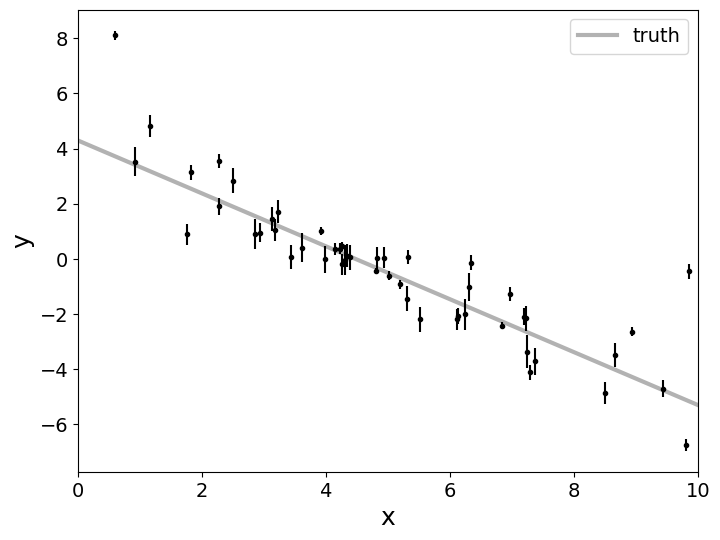

In [165]:
#plt.figure(figsize=(8,6))
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

fig,ax=plt.subplots(figsize=(8,6))

ax.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
ax.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3,label="truth")
ax.set_xlim(0, 10)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel("x",fontsize=18)
ax.set_ylabel("y",fontsize=18)
ax.legend(loc='best',fontsize=14);

The true model is shown as the thick grey line and the effect of the
underestimated uncertainties is obvious when you look at this figure.
The standard way to fit a line to these data (assuming independent Gaussian
error bars) is linear least squares.
Linear least squares is appealing because solving for the parameters—and
their associated uncertainties—is simply a linear algebraic operation.
Following the notation in [Hogg, Bovy & Lang (2010)](https://arxiv.org/abs/1008.4686), again the linear least squares solution to these
data is:

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


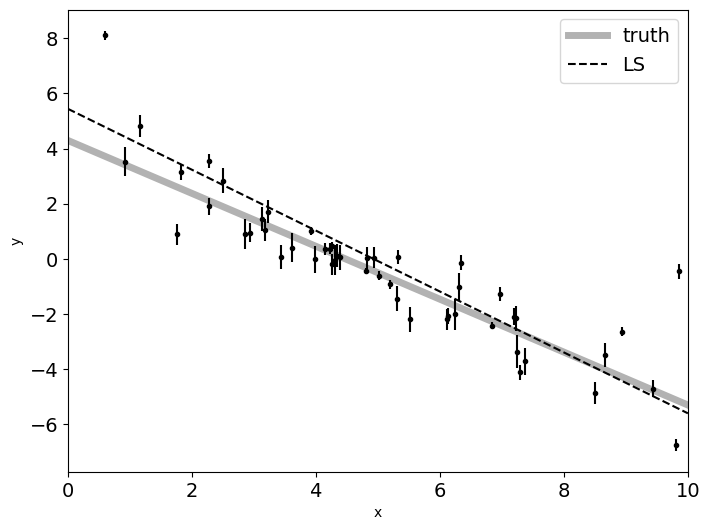

In [166]:
A = np.vander(x, 2) 
#note: this is a Vandermonde matrix: prints out x as the first column and "1" as each entry in the second.
# Think of it as "what a least-squares minimization with errors does "under the hood"
# see the notes from Hogg et al. (2010)

#print(x)
#print(A)

C = np.diag(yerr * yerr) 
#assuming that the data point measurements are independent; 
#otherwise the off-diagonal terms would be non-zero

ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

fig,ax=plt.subplots(figsize=(8,6))
ax.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
ax.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=5, label="truth")
ax.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
ax.legend(fontsize=14)
ax.set_xlim(0, 10)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel("x")
ax.set_ylabel("y");

(Note: this analytical solution may seem to come out of nowhere but see Equations 2--6 in Hogg et al. 2010).

This figure shows the least-squares estimate of the line parameters as a dashed line.
This isn't an unreasonable result but the uncertainties on the slope and
intercept seem a little small (because of the small error bars on most of the
data points).

## Setting up MCMC 


To do an MCMC you need several key ingredients.  Most of these 

* Number of samples (we will get to this later)
* A **model function**
* A **prior probability distribution** on the model parameters
* A **likelihood function** of that model being correct
* A **(log-)probability function** on the posterior distribution of the model parameters

  To make this work you also need a ...

* Starting positions for your Markov Chains
* A good **sampler** to explore explore the model phase space, compare with the data, and derive posterior distributions for parameters.   The starting point for this is the Metropolis-Hastings algorithm.   Modern professional codes can use different approaches.  E.g. ``emcee`` uses "affine-invariant ensemble sampling", which basically means a given walker uses the current positions of other walkers to 'learn' what the parameter space looks like.

Let's go through these in detail ...

#### Model Function

We follow the previous section and construct a nominal model function of ``y = mx+b`` with measurement errors of $\sigma$ and a constant parameter ``f`` describing how the errors are undersestimated.

#### Prior Probability Distribution

As mentioned before the _prior probability_ function encodes any previous knowledge that we have about the parameters: results from other experiments, physically acceptable ranges, etc.  Priors are essential for doing MCMC: all that MCMC does is draw samples from a probability distribution and you want that to be a probability distribution for your parameters.

So what should be our prior?  We can make the shape of the prior probability distribution be anything we want (its mean, standard deviation, whether it is normally distributed, log-normal, flat, etc.). But it should be reasonably motivated.  

In this example, we'll use uniform (so-called "uninformative") priors on $m$, $b$, and $ln(f)$. For example, we'll use the following conservative prior on $m$:

$$
p(m) = \left \{\begin{array}{ll}
        1 / 6 \,, & \mbox{if}\,-5 < m < 1 \\
        0 \,, & \mbox{otherwise}
    \end{array}
    \right .
$$

Note that in this particular example, we are really doing same thing as what we did with plain Monte Carlo (where we defined a uniform random sampling between some range in values).   But you can imagine other cases where you can define the prior as some gaussian centered on some value (we will get to that later in this section.)

#### Likelihood Function

We adopt the previous section's log-likelihood function:
$$ln{p}(x|\theta) = -\frac{1}{2} \sum_{i = 1}^{n}[ln(2\pi\sigma_{i}^{2})  + \frac{(x_{i}-f_{i}(\theta))^{2}}{\sigma_i^{2}}]$$

Unlike in the previous section, we will define a stand-alone Python function to describe the log-likelihood (this will become clearer below).

In code, these components look like ...

In [167]:
def log_prior(theta):
    m, b, log_f = theta
   # if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
    if -5.0 < m < 1.0 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

In [168]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Then, combining this with the definition of ``log_likelihood`` from above, the full
log-probability function is:

In [169]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

#### Starting Guesses for MCMC

We need reasonable starting guesses for the MCMC simulation to efficiently converge to regions of high likelihood to yield accurate posterior distributions.   

While professional MCMC-based packages -- e.g. ``orvara`` -- may tackle this challenge in highly sophisticated/tunable, and unique ways, one common approach for relatively simple cases is to compute a maximum likelihood (ML) fit to the data and use the ML-derived parameters as a starting point for our Markov chains.  

We can do this with SciPy's ``optimize.minimize`` function.  Here, though, we still need to give the ML fit some starting values.   In our particular example, we can just "eyeball" the trend as we did in Section 1 to say that the slope is definitely negative (say between -2 and -0.5), the intercept is probably somewhere in the 3--6 range, and the log-inflation factor is definitely not negligible (say -1,0).

We gain some insight if we consider only this function (i.e. if we just try to solve for the linear fit using this function) a...

(3,)
Maximum likelihood estimates:
m = -1.003
b = 4.528
logf = -0.790


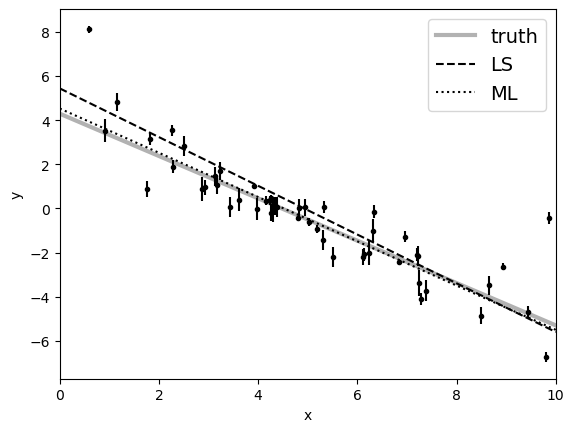

In [170]:
#maximum likelihood fit to parameters
from scipy.optimize import minimize

#np.random.seed(42) #if we comment this out, then the outcome will change each time we run this cell
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.25 * np.random.randn(3)
print(initial.shape)


# Define some range (uniform distributions): i.e. a flat/uninformative prior between these boundary conditions
m_min, m_max = -2.0, -0.5
b_min, b_max = 3,6
#f_min, f_max = 0.0, 1.0
f_min,f_max=-1, 0 #this is actually log(f)

# We need starting points for the maximum-likelihood fit.  Give it something random for each parameter over the allowed phase space.
m_samples = np.random.uniform(m_min, m_max, 1)
b_samples = np.random.uniform(b_min, b_max, 1)
f_samples = np.random.uniform(f_min, f_max, 1)

initial=np.array([m_samples,b_samples,f_samples]).squeeze()

soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("logf = {0:.3f}".format((log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

#print('solx',soln.x)
initial=soln.x

#print(initial.shape)

#print(len(soln.x))

This is _a lot_ closer to the ground-truth value**.   Now, how do we estimate the uncertainties on m and b? What's more, we probably don't really care too much about the value of f but it seems worthwhile to propagate any uncertainties about its value to our final estimates of m and b. This is where MCMC comes in.  

So we proceed with the final ingredient of MCMC: the MCMC sampler.


** Note: Scipy.optimize _minimizes_ functions whereas we would like to _maximize_ the likelihood. This goal is equivalent to minimizing the negative likelihood (or in this case, the negative log likelihood). 

### Doing MCMC

Before using a professional sampler like ``emcee``, it's instructive to see how a simple Metropolis–Hastings (MH) sampler works “by hand.” We will first do a single "walker" MH sampler and then expand this to multiple walkers.  Then we will use these analyses to explore key concepts with MCMC: **burn-in**, **autocorrelation**/thinning chains, etc.   

### _A Super-Simple Example with the Metropolis–Hastings Algorithm (Single Walker)_

In [183]:
def simple_metropolis_hastings(log_prob_func, initial_theta, stepsize, nsteps, x, y, yerr):
    ndim=len(initial_theta)
    chain = np.zeros((nsteps, ndim))
    chain[0] = initial_theta
    current_logp = log_probability(initial_theta,x,y,yerr)

    for i in range(1, nsteps):
        proposal = chain[i-1] + stepsize * np.random.randn(ndim)
        proposal_logp = log_probability(proposal,x,y,yerr)

        # acceptance probability (symmetric proposal → q cancels)
        if np.log(np.random.rand()) < (proposal_logp - current_logp):
            chain[i] = proposal
            current_logp = proposal_logp
        else:
            chain[i] = chain[i-1]
    return chain

stepsize = np.array([0.05, 0.05, 0.02])
nsteps = 5000

# Run MH sampler
post = simple_metropolis_hastings(log_probability,initial,stepsize,nsteps,x,y,yerr)

Posterior mean (m, b),log(f): [-1.05158086  4.75176092 -0.8266499 ]
the 68% CI for m is -1.135 -0.977
the 68% CI for b is 4.401 5.135
the 68% CI for log(f) is -0.980 -0.705


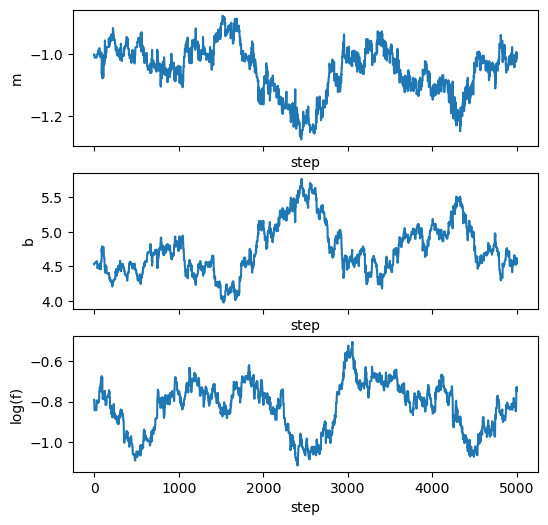

In [185]:
labels=['m','b','log(f)']

fig, axes = plt.subplots(3, 1, figsize=(6,6), sharex=True)
print("Posterior mean (m, b),log(f):", post.mean(axis=0))
for i,ax in enumerate(axes):
 ax.plot(post[:, i])
 ax.set_xlabel('step')
 ax.set_ylabel(labels[i])
 print("the 68% CI for {0:s} is {1:.3f} {2:.3f}".format(labels[i], 
    np.nanpercentile(post[:,i],16,axis=0),np.nanpercentile(post[:,i],84,axis=0)))
plt.show()

### _Simple Metropolis-Hastings Algorithm (Multiple Walkers)_

Now we will do the same thing with _multiple_ walkers, each exploring their own path through the parameter phase space.  

In [186]:
from tqdm import trange
def multiwalker_metropolis_hastings(log_prob_func, initial_thetas, stepsize, nsteps, x, y, yerr):
    nwalkers,ndim=initial_thetas.shape
    chains = np.zeros((nwalkers, nsteps,ndim))
    chains[:,0,:]=initial_thetas
    
    current_logp = np.array([log_probability(initial_thetas[i],x,y,yerr) for i in range(nwalkers)])
    print('the shape is ',current_logp.shape)

    for i in trange(1, nsteps,desc="Multi-Walker MH Sampling"): #note: this adds a progress bar: if you don't have tqdm see below line
    #for i in range(1, nsteps):
        for j in range(0,nwalkers):
             current=chains[j,i-1]
             proposal = current + stepsize * np.random.randn(ndim)
             proposal_logp = log_probability(proposal,x,y,yerr)
         #print('the next shape is',proposal_logp)

        # acceptance probability (symmetric proposal → q cancels)
             if np.log(np.random.rand()) < (proposal_logp - current_logp[j]):
                chains[j,i] = proposal
                current_logp[j] = proposal_logp
             else:
                chains[j,i] = current
    return chains

In [187]:
stepsize = np.array([0.05, 0.05, 0.02])
nsteps = 5000

nwalker=50
ndim=len(soln.x)

#set the initial position of nwalkers and 3 model parameters equal to a small ball clustered around the ML solution
initial_pos = soln.x + 1e-4 * np.random.randn(nwalker, ndim) 
print('the pos is',initial_pos.shape)

# Run MH sampler
samples = multiwalker_metropolis_hastings(log_probability,initial_pos,stepsize,nsteps,x,y,yerr)

the pos is (50, 3)
the shape is  (50,)


Mult-Walker MH Sampling: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:02<00:00, 1988.67it/s]


The above example had a bunch of nested loops.  We can do better: i.e. we can vectorize this code to get better speed.

In [ ]:
def multiwalker_metropolis_hastings_vect(log_prob_func, initial_thetas, stepsize, nsteps, x, y, yerr):
    nwalkers,ndim=initial_thetas.shape
    chains = np.zeros((nwalkers, nsteps,ndim))
    chains[:,0,:]=initial_thetas

    current_logp = np.array([log_probability(theta,x,y,yerr) for theta in initial_thetas])
    print('the shape is ',current_logp.shape)
    
    for i in trange(1, nsteps,desc="Multi-Walker MH Sampling (Vectorized)"): #note: this adds a progress bar: if you don't have tqdm see below line
    #for i in range(1, nsteps):

        proposals = chains[:, i-1, :] + stepsize * np.random.randn(nwalkers, ndim)
        proposal_logp = np.array([log_probability(proposals[j],x,y,yerr) for j in range(nwalkers)])

        accept = np.log(np.random.rand(nwalkers)) < (proposal_logp - current_logp) #gives a boolean array [True, False, True, ...], etc
        chains[:, i, :] = chains[:, i-1, :]
        
        chains[accept, i, :] = proposals[accept] #where accept = True, set that value of chains[ ,i,:] to proposals
        current_logp[accept] = proposal_logp[accept]
        
        
    return chains

In [200]:
stepsize = np.array([0.05, 0.05, 0.02])
nsteps = 5001

nwalker=50
ndim=len(soln.x)

#set the initial position of nwalkers and 3 model parameters equal to a small ball clustered around the ML solution
initial_pos = soln.x + 1e-4 * np.random.randn(nwalker, ndim) 
print('the pos is',initial_pos.shape)

# Run MH sampler
samples = multiwalker_metropolis_hastings_vect(log_probability,initial_pos,stepsize,nsteps,x,y,yerr)

the pos is (50, 3)
the shape is  (50,)


Multi-Walker MH Sampling (Vectorized): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3177.21it/s]


(245050, 3)
Posterior mean (m, b,log(f)): [-1.01116931  4.56445826 -0.77573889]
the 68% CI [[-1.09158127  4.21167115 -0.92167572]
 [-0.93379914  4.93136558 -0.62514313]]
[-1.01116931  4.56445826 -0.77573889]
[-0.92167572 -0.62514313]


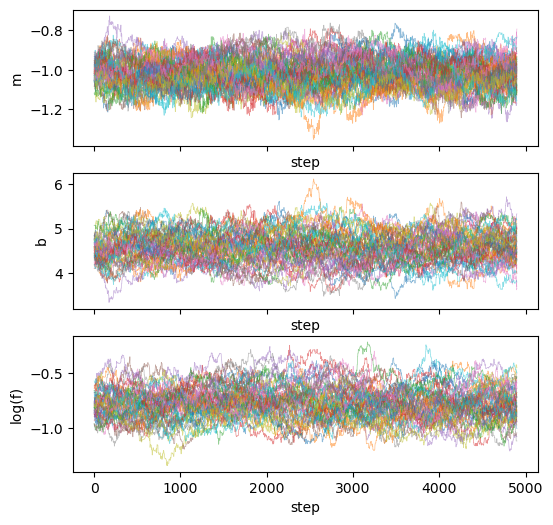

In [201]:
# Discard burn-in
burn = 100
post = samples[:,burn:,:]
samples2=post.reshape(nwalker*(nsteps-burn),-1)
print(samples2.shape)

print("Posterior mean (m, b,log(f)):", np.nanmedian(samples2,axis=0))
print("the 68% CI",np.nanpercentile(samples2,[16,84],axis=0))

blah=np.nanpercentile(samples2,50,axis=0)
blah2=np.nanpercentile(samples2,[16,84],axis=0)
print(blah)
print(blah2[:,2])

labels=['m','b','log(f)']

fig, axes = plt.subplots(3, 1, figsize=(6,6), sharex=True)
for i,ax in enumerate(axes):
 for walker in range(nwalker):
        ax.plot(post[walker, :, i], alpha=0.5, lw=0.5)
 ax.set_xlabel('step')
 ax.set_ylabel(labels[i])
plt.show()
 

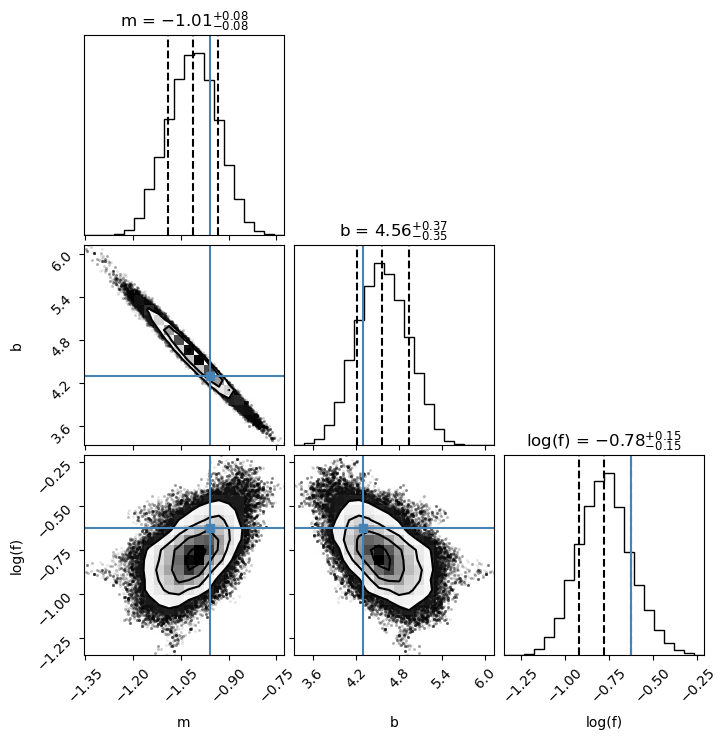

In [202]:
fig = corner.corner(samples2,show_titles=True,truths=[m_true, b_true, np.log(f_true)],
                     labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

## Linking to Part 2

In Part 1 we focused on the core ideas and mechanics of MCMC. In Part 2 we will apply these ideas to a more realistic scientific problem where the dimensionality increases and the posterior can be multimodal. We'll reuse the same logic—define priors, build a log-likelihood, run `emcee`—but the diagnostics (mixing, autocorrelation) become even more important.